<a href="https://colab.research.google.com/github/PranjalDureja0002/pranjaldureja/blob/master/MODEL_VIDEO1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Setup

%cd /content
!git clone --depth 1 https://github.com/eyaler/first-order-model
!wget --no-check-certificate -nc https://openavatarify.s3.amazonaws.com/weights/vox-adv-cpk.pth.tar
!wget --no-check-certificate -nc https://eyalgruss.com/fomm/vox-adv-cpk.pth.tar

!mkdir -p /root/.cache/torch/hub/checkpoints
%cd /root/.cache/torch/hub/checkpoints
!wget --no-check-certificate -nc https://eyalgruss.com/fomm/s3fd-619a316812.pth
!wget --no-check-certificate -nc https://eyalgruss.com/fomm/2DFAN4-11f355bf06.pth.tar
%cd /content

!pip install -U youtube-dl
!pip install -U imageio
!pip install -U imageio-ffmpeg
!pip install git+https://github.com/1adrianb/face-alignment@v1.0.1

/content
Cloning into 'first-order-model'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 54 (delta 7), reused 35 (delta 3), pack-reused 0
Unpacking objects: 100% (54/54), done.
--2021-05-14 14:00:43--  https://openavatarify.s3.amazonaws.com/weights/vox-adv-cpk.pth.tar
Resolving openavatarify.s3.amazonaws.com (openavatarify.s3.amazonaws.com)... 52.216.99.67
Connecting to openavatarify.s3.amazonaws.com (openavatarify.s3.amazonaws.com)|52.216.99.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239313439 (228M) [application/x-tar]
Saving to: ‘vox-adv-cpk.pth.tar’

vox-adv-cpk.pth.tar 100%[===================>] 228.23M  44.8MB/s    in 5.7s    

2021-05-14 14:00:49 (40.2 MB/s) - ‘vox-adv-cpk.pth.tar’ saved [239313439/239313439]

File ‘vox-adv-cpk.pth.tar’ already there; not retrieving.

/root/.cache/torch/hub/checkpoints
--2021-05-14 14:00:49--  https://eyalgrus

## FIRST ORDER MOTION ANIMATION MODEL 

In [3]:
#@title Optionally upload local Driver video { run: "auto" }
manually_upload_video = True #@param {type:"boolean"}
if manually_upload_video:
  from google.colab import files
  import shutil

  %cd /content/sample_data
  try:
    uploaded = files.upload()
  except Exception as e:
    %cd /content
    raise e

  for fn in uploaded:
    shutil.move('/content/sample_data/'+fn, '/content/video')
    break
  %cd /content

/content/sample_data


Saving as1.mp4 to as1.mp4
/content


In [4]:
#@title Optionally upload local Avatar image { run: "auto" }
manually_upload_image = True #@param {type:"boolean"}
if manually_upload_image:
  from google.colab import files
  import shutil

  %cd /content/sample_data
  try:
    uploaded = files.upload()
  except Exception as e:
    %cd /content
    raise e

  for fn in uploaded:
    shutil.move('/content/sample_data/'+fn, '/content/image')
    break
  %cd /content

/content/sample_data


Saving re1.jpg to re1.jpg
/content


## PLAYING WITH THE VIDEO 

In [5]:
#@title Optionally shorten Driver video
start_seconds = 0 #@param {type:"number"}
duration_seconds =  60#@param {type:"number"}
start_seconds = max(start_seconds,0)
duration_seconds = max(duration_seconds,0)

if duration_seconds:
  !mv /content/video /content/full_video
  !ffmpeg -ss $start_seconds -t $duration_seconds -i /content/full_video -f mp4 /content/video -y

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

## PERFORMING CROP OPERATION

In [6]:
#@title Prepare assets
#@markdown If you ran out of RAM this means that the video is too large. You can shorten it above.

center_video_to_head = True #@param {type:"boolean"}
crop_video_to_head = True #@param {type:"boolean"}
video_crop_expansion_factor = 2.5 #@param {type:"number"}
center_image_to_head = True #@param {type:"boolean"}
crop_image_to_head = True #@param {type:"boolean"}
image_crop_expansion_factor = 2.5 #@param {type:"number"}
video_crop_expansion_factor = max(video_crop_expansion_factor, 1)
image_crop_expansion_factor = max(image_crop_expansion_factor, 1)

import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML, clear_output
import warnings
warnings.filterwarnings("ignore")

import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=True,
                                      device='cuda')

def create_bounding_box(target_landmarks, expansion_factor=1):
    target_landmarks = np.array(target_landmarks)
    x_y_min = target_landmarks.reshape(-1, 68, 2).min(axis=1)
    x_y_max = target_landmarks.reshape(-1, 68, 2).max(axis=1)
    expansion_factor = (expansion_factor-1)/2
    bb_expansion_x = (x_y_max[:, 0] - x_y_min[:, 0]) * expansion_factor
    bb_expansion_y = (x_y_max[:, 1] - x_y_min[:, 1]) * expansion_factor
    x_y_min[:, 0] -= bb_expansion_x
    x_y_max[:, 0] += bb_expansion_x
    x_y_min[:, 1] -= bb_expansion_y
    x_y_max[:, 1] += bb_expansion_y
    return np.hstack((x_y_min, x_y_max-x_y_min))

def fix_dims(im):
    if im.ndim == 2:
        im = np.tile(im[..., None], [1, 1, 3])
    return im[...,:3]

def get_crop(im, center_face=True, crop_face=True, expansion_factor=1, landmarks=None):
    im = fix_dims(im)
    if (center_face or crop_face) and not landmarks:
        landmarks = fa.get_landmarks_from_image(im)
    if (center_face or crop_face) and landmarks:
        rects = create_bounding_box(landmarks, expansion_factor=expansion_factor)
        x0,y0,w,h = sorted(rects, key=lambda x: x[2]*x[3])[-1]
        if crop_face:
            s = max(h, w)
            x0 += (w-s)//2
            x1 = x0 + s
            y0 += (h-s)//2
            y1 = y0 + s
        else:
            img_h,img_w = im.shape[:2]
            img_s = min(img_h,img_w)
            x0 = min(max(0, x0+(w-img_s)//2), img_w-img_s)
            x1 = x0 + img_s
            y0 = min(max(0, y0+(h-img_s)//2), img_h-img_s)
            y1 = y0 + img_s            
    else:
        h,w = im.shape[:2]
        s = min(h,w)
        x0 = (w-s)//2
        x1 = x0 + s
        y0 = (h-s)//2
        y1 = y0 + s
    return int(x0),int(x1),int(y0),int(y1)

def pad_crop_resize(im, x0=None, x1=None, y0=None, y1=None, new_h=256, new_w=256):
    im = fix_dims(im)
    h,w = im.shape[:2]
    if x0 is None:
      x0 = 0
    if x1 is None:
      x1 = w
    if y0 is None:
      y0 = 0
    if y1 is None:
      y1 = h
    if x0<0 or x1>w or y0<0 or y1>h:
        im = np.pad(im, pad_width=[(max(-y0,0),max(y1-h,0)),(max(-x0,0),max(x1-w,0)),(0,0)], mode='edge')
    return resize(im[max(y0,0):y1-min(y0,0),max(x0,0):x1-min(x0,0)], (new_h, new_w))

source_image = imageio.imread('/content/image')
source_image = pad_crop_resize(source_image, *get_crop(source_image, center_face=center_image_to_head, crop_face=crop_image_to_head, expansion_factor=image_crop_expansion_factor))

with imageio.get_reader('/content/video', format='mp4') as reader:
  fps = reader.get_meta_data()['fps']

  driving_video = []
  landmarks = None
  try:
      for i,im in enumerate(reader):
          if not crop_video_to_head:
              break
          landmarks = fa.get_landmarks_from_image(im)
          if landmarks:
              break
      x0,x1,y0,y1 = get_crop(im, center_face=center_video_to_head, crop_face=crop_video_to_head, expansion_factor=video_crop_expansion_factor, landmarks=landmarks)
      reader.set_image_index(0)
      for im in reader:
          driving_video.append(pad_crop_resize(im,x0,x1,y0,y1))
  except RuntimeError:
      pass

def vid_display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani

clear_output()
if landmarks:
  print('first found head in frame %d'%i)
HTML(vid_display(source_image, driving_video).to_html5_video())

first found head in frame 0



best frame=465


(-0.5, 511.5, 255.5, -0.5)

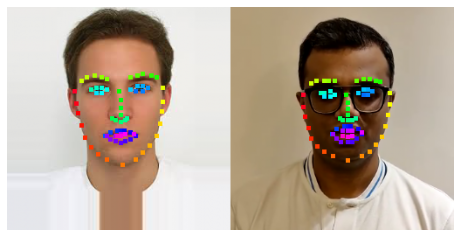

In [7]:
#@title Find best alignment

%cd /content/first-order-model
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='/content/first-order-model/config/vox-adv-256.yaml', 
                            checkpoint_path='/content/vox-adv-cpk.pth.tar')

from scipy.spatial import ConvexHull
def normalize_kp(kps):
    max_area = 0
    max_kp = None
    for kp in kps:
        kp = kp - kp.mean(axis=0, keepdims=True)
        area = ConvexHull(kp[:, :2]).volume
        area = np.sqrt(area)
        kp[:, :2] = kp[:, :2] / area
        if area>max_area:
          max_area = area
          max_kp = kp
    return max_kp

from tqdm import tqdm

kp_source = fa.get_landmarks_from_image(255 * source_image)
if kp_source:
  norm_kp_source = normalize_kp(kp_source)

norm  = float('inf')
best = 0
best_kp_driving = None
for i, image in tqdm(enumerate(driving_video)):
  kp_driving = fa.get_landmarks_from_image(255 * image)
  if kp_driving:
    norm_kp_driving = normalize_kp(kp_driving)
    if kp_source:
      new_norm = (np.abs(norm_kp_source - norm_kp_driving) ** 2).sum()
      if new_norm < norm:
        norm = new_norm
        best = i
        best_kp_driving = kp_driving
    else:
      best_kp_driving = kp_driving
      break

from logger import Visualizer
vis = Visualizer(kp_size=3, colormap='gist_rainbow')
source_with_kp = vis.draw_image_with_kp(source_image, kp_source[0]*2/np.array(source_image.shape[:2][::-1])[np.newaxis]-1) if kp_source else source_image
driving_with_kp = vis.draw_image_with_kp(driving_video[best], best_kp_driving[0]*2/np.array(driving_video[best].shape[:2][::-1])[np.newaxis]-1) if best_kp_driving else driving_video[best]

clear_output()
print('\nbest frame=%d'%best)
plt.figure(figsize=(8, 6))
plt.imshow(np.concatenate([source_with_kp, driving_with_kp], axis=1))
plt.axis('off')

In [8]:
#@title Animate

exaggerate_factor = 1 #@param {type:"slider", min:0.1, max:5, step:0.1}
adapt_movement_scale = True #@param {type:"boolean"}
use_relative_movement = True #@param {type:"boolean"}
use_relative_jacobian = True #@param {type:"boolean"}

import torch
from skimage import img_as_ubyte

def full_normalize_kp(kp_source, kp_driving, kp_driving_initial, adapt_movement_scale=False,
                 use_relative_movement=False, use_relative_jacobian=False, exaggerate_factor=1):
    if adapt_movement_scale:
        source_area = ConvexHull(kp_source['value'][0].data.cpu().numpy()).volume
        driving_area = ConvexHull(kp_driving_initial['value'][0].data.cpu().numpy()).volume
        adapt_movement_scale = np.sqrt(source_area) / np.sqrt(driving_area)
    else:
        adapt_movement_scale = 1

    kp_new = {k: v for k, v in kp_driving.items()}

    if use_relative_movement:
        kp_value_diff = (kp_driving['value'] - kp_driving_initial['value'])
        kp_value_diff *= adapt_movement_scale * exaggerate_factor
        kp_new['value'] = kp_value_diff + kp_source['value']

        if use_relative_jacobian:
            jacobian_diff = torch.matmul(kp_driving['jacobian'], torch.inverse(kp_driving_initial['jacobian']))
            kp_new['jacobian'] = torch.matmul(jacobian_diff, kp_source['jacobian'])

    return kp_new

def make_animation(source_image, driving_video, generator, kp_detector, adapt_movement_scale=False,
                 use_relative_movement=False, use_relative_jacobian=False, cpu=False, exaggerate_factor=1):
    with torch.no_grad():
        predictions = []
        source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source = source.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
        kp_source = kp_detector(source)
        kp_driving_initial = kp_detector(driving[:, :, 0])

        for frame_idx in tqdm(range(driving.shape[2])):
            driving_frame = driving[:, :, frame_idx]
            if not cpu:
                driving_frame = driving_frame.cuda()
            kp_driving = kp_detector(driving_frame)
            kp_norm = full_normalize_kp(kp_source=kp_source, kp_driving=kp_driving,
                                   kp_driving_initial=kp_driving_initial, adapt_movement_scale=adapt_movement_scale, use_relative_movement=use_relative_movement,
                                   use_relative_jacobian=use_relative_jacobian, exaggerate_factor=exaggerate_factor)
            out = generator(source, kp_source=kp_source, kp_driving=kp_norm)

            predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
    return predictions

predictions_forward = make_animation(source_image, driving_video[best:], generator, kp_detector, adapt_movement_scale=adapt_movement_scale, use_relative_movement=use_relative_movement,
                                   use_relative_jacobian=use_relative_jacobian, exaggerate_factor=exaggerate_factor)
predictions_backward = make_animation(source_image, driving_video[:(best+1)][::-1], generator, kp_detector, adapt_movement_scale=adapt_movement_scale, use_relative_movement=use_relative_movement,
                                   use_relative_jacobian=use_relative_jacobian, exaggerate_factor=exaggerate_factor)

imageio.mimsave('/content/generated.mp4', [img_as_ubyte(frame) for frame in predictions_backward[::-1] + predictions_forward[1:]], fps=fps)
!ffmpeg -i /content/generated.mp4 -i /content/video -c:v libx264 -c:a aac -map 0:v -map 1:a? -pix_fmt yuv420p /content/final.mp4 -profile:v baseline -movflags +faststart -y
#video can be downloaded from /content/final.mp4

clear_output()
HTML(vid_display(source_image, driving_video, predictions_backward[::-1] + predictions_forward[1:]).to_html5_video())



In [ ]:
#@title Download
#@markdown 1. If it fails try running this cell again.
#@markdown 2. Alternatively, you can manually download "final.mp4" from the folder on the left (click "Refresh" if missing).

print() #see https://github.com/googlecolab/colabtools/issues/468
from google.colab import files
files.download('/content/final.mp4') #fails for Firefox private window

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PERFORMING VIDEO ENHANCEMENT THROUGH RESOLUTION IMPROVEMENTS

In [ ]:
#@title ##**Clone the repository and download the necessary components** { display-mode: "form" }
%cd /content/
!git clone https://github.com/xinntao/ESRGAN.git
!cp -r /content/final.mp4 ESRGAN/
%cd /content/ESRGAN
!git checkout tags/old-arch
model_url = "https://www.dropbox.com/s/vouc15j8jjp2o5n/RRDB_ESRGAN_x4_old_arch.pth?dl=0"
!wget $model_url --content-disposition -P models
import architecture as arch
import os.path
!mkdir frames
!rm -rf results/baboon_ESRGAN.png
clear_output()

In [ ]:
import cv2

In [ ]:
#@title ##**Split the video into frames** { display-mode: "form" }
frames_of_video = int(cv2.VideoCapture("final.mp4").get(cv2.CAP_PROP_FRAME_COUNT))
fps_of_video = int(cv2.VideoCapture("final.mp4").get(cv2.CAP_PROP_FPS))
vidcap = cv2.VideoCapture('final.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("frames/frame%09d.jpg" % count, image)
  success,image = vidcap.read()
  count += 1

In [ ]:
import glob

In [ ]:
#@title ##**Upscale resolution and improve frame quality** { display-mode: "form" }
#@markdown **How many times to upscale the resolution:**
upscale = 4 #@param {type: "slider", min: 4, max: 8}
%env CUDA_VISIBLE_DEVICES=0
device = torch.device('cuda')
model = arch.RRDB_Net(3, 3, 64, 23, gc=32, upscale=upscale, norm_type=None, act_type='leakyrelu', \
                        mode='CNA', res_scale=1, upsample_mode='upconv')
model.load_state_dict(torch.load('models/{:s}'.format('RRDB_ESRGAN_x4_old_arch.pth')), strict=True)
model.eval()
for k, v in model.named_parameters():
    v.requires_grad = False
model = model.to(device)

count_frames = 0

for path in glob.glob('frames/*'):
    base = os.path.splitext(os.path.basename(path))[0]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(device)

    output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()
    path = 'results/{:s}_rlt.png'.format(base)
    cv2.imwrite(path, output)
    count_frames += 1
    clear_output()
    print("Processed: {} из {}".format(str(count_frames), str(frames_of_video)))
clear_output()

Processed: 12 из 295


KeyboardInterrupt: ignored

In [ ]:
import io

In [ ]:
import base64

In [ ]:
#@title ##**Collecting frames in a video file** { display-mode: "form" }
frames = []
img = os.listdir("results/")
img.sort()
for i in img:
  frames.append(imageio.imread("results/"+i))
frames = np.array(frames)
imageio.mimsave("upscale_video.mp4", frames, fps=fps_of_video)

print('Сборка завершена')
!cp -r upscale_video.mp4 /content/upscale_video.mp4
!cp -r upscale_video.mp4 /content/final.mp4
clear_output()

video = io.open('/content/upscale_video.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="400" height="400" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

In [ ]:
#@title ##**Download the result** { display-mode: "form" }
!cp -r upscale_video.mp4 /content/upscale_video.mp4
!cp -r upscale_video.mp4 /content/final.mp4
files.download("/content/upscale_video.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Dub it!
#@markdown 1. Choose audio (you can also enter a YouTube or similar URL, or a manually uploaded file name):
audio = 'Go home' #@param ['Dangerous time', 'Go home', 'Sound of victory', 'Ernie and Bert (2 speakers)', '11,780 votes (3 speakers)', 'מלפפונים חמוצים', 'שונאת שמאלנים', 'אני שולה', 'אריק ובנץ (2 דוברים)', 'אריק ובנץ וגנץ (3 דוברים)', 'Grab from uploaded video'] {allow-input: true}
#@markdown 2. Optionally untick "smooth_face_detection" to disable temporal smoothing of face coordinates:
smooth_face_detection = True #@param {type: "boolean"}
#@markdown 3. Optionally tick "override_face_detection" to manually asign face coordinates:
override_face_detection = False #@param {type: "boolean"}
left = 0# @param {type: "integer"}
top = 0# @param {type: "integer"}
width = 1080 #@param {type: "integer"}
height = 1920 #@param {type: "integer"}
#@markdown 4. Optionally tick "switch_speakers" to switch between visual media files with the change of speakers:
switch_speakers = False #@param {type: "boolean"}
#@markdown 5. Choose model for speaker diarization:
model = 'pyannote-audio DIHARD' #@param ['pyAudioAnalysis', 'pyannote-audio DIHARD','pyannote-audio AMI']
#@markdown 6. Optionally tick "reuse_files" to reuse previously uploaded files:
reuse_files = False #@param {type: "boolean"}
#@markdoצwn 7. Press the play (triangle) button on the left.
#@markdown 8. Press "Browse" below, and upload image(s) or video(s) (if not reusing files).
#@markdown 9. If the resulting videos are too large, the Colab might disconnect, but you may still manually download the .mp4 from the folder on the left (click "Refresh" if missing).

from google.colab import files
try:
  inputs
except NameError:
  reuse_files = False

if not reuse_files:
  %cd /content/sample_data
  !rm -rf *
  inputs = files.upload()

if inputs:
  %tensorflow_version 1.x
  %cd /content
  !pip install pyannote.audio==1.1.1
  !pip install hmmlearn==0.2.2
  !pip install eyeD3==0.9.5
  !pip install pydub==0.24.0
  !pip install pyAudioAnalysis
  !git clone --depth 1 https://github.com/eyaler/Wav2Lip.git
  import os
  if not os.path.exists('/content/Wav2Lip/checkpoints/wav2lip_gan.pth'):
    !gdown https://drive.google.com/uc?id=1dwHujX7RVNCvdR1RR93z0FS2T2yzqup9 -O /content/Wav2Lip/checkpoints/wav2lip_gan.pth
  !wget --no-check-certificate -nc https://eyalgruss.com/fomm/wav2lip_gan.pth -O /content/Wav2Lip/checkpoints/wav2lip_gan.pth
  #!wget --no-check-certificate -nc https://eyalgruss.com/fomm/wav2lip.pth -O /content/Wav2Lip/checkpoints/wav2lip.pth
  !wget --no-check-certificate -nc https://eyalgruss.com/fomm/s3fd-619a316812.pth -O /content/Wav2Lip/face_detection/detection/sfd/s3fd.pth
  !pip install -U youtube-dl
  grab = False
  manual = False
  if '://' in audio:
    if os.path.exists('/content/custom.mp3'):
      os.remove('/content/custom.mp3')
    !youtube-dl --extract-audio --audio-format mp3 '$audio' -o /content/custom.mp3
    audio = 'custom'
  elif audio=='Dangerous time':
    audio = 'dangerous'
    if not os.path.exists('/content/dangerous.mp3'):
      !youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=cQ54GDm1eL0 -o /content/dangerous.mp3
  elif audio=='Go home':
    audio = 'gohome'
    !wget --no-check-certificate -nc https://eyalgruss.com/fomm/gohome.mp3
  elif audio=='Sound of victory':
    audio = 'victory'
    if not os.path.exists('/content/victory.mp3'):
      !youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=Nu96Fhl1Gjo -o /content/victory.mp3
  elif audio=='Ernie and Bert (2 speakers)':
    audio = 'dialog_eng'
    if not os.path.exists('/content/dialog_eng.mp3'):
      !youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=I78YAciQpr0 -o /content/dialog_eng.mp3
  elif audio == '11,780 votes (3 speakers)':
    audio = 'trialog_eng'
    if not os.path.exists('/content/trialog_eng.mp3'):
      !youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=o3hrN0cP58Y -o /content/trialog_heb.mp3
  elif audio == 'מלפפונים חמוצים':
    audio = 'melaflefon'
    !wget --no-check-certificate -nc https://eyalgruss.com/fomm/melaflefon.mp3
  elif audio == 'שונאת שמאלנים':
    audio = 'sonet'
    !wget --no-check-certificate -nc https://eyalgruss.com/fomm/sonet.mp3
  elif audio == 'אני שולה':
    audio = 'shoula'
    !wget --no-check-certificate -nc https://eyalgruss.com/fomm/shoula.mp3
  elif audio == 'אריק ובנץ (2 דוברים)':
    audio = 'dialog_heb'
    if not os.path.exists('/content/dialog_heb.mp3'):
      !youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=rrZ3bo4VmpQ -o /content/dialog_heb.mp3
  elif audio == 'אריק ובנץ וגנץ (3 דוברים)':
    audio = 'trialog_heb'
    if not os.path.exists('/content/trialog_heb.mp3'):
      !youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=HOKJnkG5MXQ -o /content/trialog_heb.mp3
  elif audio == 'Grab from uploaded video':
    grab = True
  elif audio == '':
    audio = 'custom'
  else:
    manual = True
  audio = '/content/'+audio
  if manual:
    for ext in ['mp3','wav','m4a','aac','ogg','flac','wma','aiff','opus','amr','ac3','mp4']:
      if os.path.exists(audio+'.'+ext):    
        audio += '.'+ext
        break
      if os.path.exists(audio+'.'+ext.upper()):    
        audio += '.'+ext.upper()
        break
  else:
    audio += '.mp3'      
  assert grab or os.path.exists(audio), 'Error: could not find audio file: '+audio

  %cd /content/Wav2Lip
  outputs = []
  for im in inputs:
    !rm -rf /content/Wav2Lip/temp/*
    infile = '/content/sample_data/'+im
    ext = infile.rsplit('.',1)[1]
    if ext != ext.lower() or "'" in infile:
      ext = ext.lower()
      lower = infile.rsplit('.',1)[0].replace("'",'')+'.'+ext
      !rm -rf '$lower'
      os.rename(infile, lower)
      infile = lower
    outfile = '/content/'+im.rsplit('.',1)[0].replace("'",'')+'_out.mp4'
    !rm -rf '$outfile'
    if grab:
      audio = infile
    elif "'" in audio:
      fix = audio.replace("'",'')
      !rm -rf '$fix'
      os.rename(audio, fix)
      audio = fix
    if not override_face_detection:
      nosmooth = '' if smooth_face_detection else '--nosmooth'
      !python inference.py --checkpoint_path checkpoints/wav2lip_gan.pth --face '$infile' --audio \"'$audio'\" --pads 0 20 0 0 $nosmooth --outfile \"'$outfile'\"
    if override_face_detection or os.path.exists('/content/Wav2Lip/temp/faulty_frame.jpg'):
      import cv2
      print('\nFace not detected - will use whole frame')
      if ext in ['jpg', 'png', 'jpeg']:
        frame = cv2.imread(infile)
      else:
        video_stream = cv2.VideoCapture(infile)
        still_reading, frame = video_stream.read()
      y2,x2 = frame.shape[:2]
      if override_face_detection:
        x1 = left
        y1 = top
        x2 = min(left+width, x2)
        y2 = min(top+height, y2)
      else:
        x1 = y1 = 0
        if x2>y2:
          x1 = (x2-y2)//2
          x2 = x1+y2
      !python inference.py --checkpoint_path checkpoints/wav2lip_gan.pth --face '$infile' --audio \"'$audio'\" --box $y1 $y2 $x1 $x2 --pads 0 20 0 0 --outfile \"'$outfile'\"
    outputs.append(outfile)

  wav = None
  if switch_speakers and len(outputs)>1 and not grab:
    wav = audio.rsplit('.',1)[0]+'.wav'
    !ffmpeg -i '$audio' '$wav' -y
    min_dt = 0.5
    if model.startswith('pyannote-audio'):
      import torch
      import pyannote.core #https://github.com/pyannote/pyannote-audio/issues/561
      from pyannote.audio.features.utils import get_audio_duration
      if model.endswith('AMI'):
        pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia_ami')
      else:
        pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia')
      cls = pipeline({'audio':wav})
      tmp_segs = [((s.start,s.end),l) for s,_,l in cls.itertracks(yield_label=True)]
      segs = []
      prev_ind = None 
      prev_start = None
      for (start,end),ind in tmp_segs+[((get_audio_duration({'audio':wav}),None),None)]:
        if ind!=prev_ind:
          if prev_ind is not None:
            segs.append([(prev_start,start),prev_ind])
          prev_ind = ind
          prev_start = start
    elif model=='pyAudioAnalysis':
      from pyAudioAnalysis import audioSegmentation as aS
      mid_window=2
      mid_step=0.2
      short_window=0.05
      lda_dim=0 #35
      cls = aS.speaker_diarization(wav, len(outputs), mid_window=mid_window, mid_step=mid_step, short_window=short_window, lda_dim=lda_dim)
      segs = list(zip(*aS.labels_to_segments(cls, mid_step)))
    deleted = 0
    unified = 0
    if min_dt:
      for i in range(len(segs)-1,0,-1):
        if segs[i][0][1]-segs[i][0][0]<min_dt:
          if i+1<len(segs) and segs[i-1][1] == segs[i+1][1]:
            segs[i-1] = ((segs[i-1][0][0],segs[i+1][0][1]),segs[i-1][1])
            del segs[i+1]
            unified += 1
          else:
            segs[i-1] = ((segs[i-1][0][0],segs[i][0][1]),segs[i-1][1])
          del segs[i]
          deleted += 1
    inds = {}
    my_ind = 0
    with open('/content/list.txt','w',encoding='utf8') as f:
      for i,((start,end),ind) in enumerate(segs):
        if ind not in inds:
          inds[ind] = my_ind%len(outputs)
          my_ind += 1
        f.write("file '%s'\n"%outputs[inds[ind]])
        if i>0:
          f.write('inpoint %f\n'%start)
        if i<len(segs)-1:
          f.write('outpoint %f\n'%end)
    !ffmpeg -f concat -safe 0 -i /content/list.txt -i "{outputs[0]}" -map 0:v -map 1:a -c:v libx264 -c:a aac -vf "crop=trunc(iw/2)*2:trunc(ih/2)*2" -pix_fmt yuv420p -profile:v baseline -movflags +faststart /content/combined.mp4 -y
    new_outputs = ['/content/combined.mp4']
    if len(outputs)==2:
      with open('/content/list2.txt','w',encoding='utf8') as f:
        for i,((start,end),ind) in enumerate(segs):
          f.write("file '%s'\n"%outputs[1-inds[ind]])
          if i>0:
            f.write('inpoint %f\n'%start)
          if i<len(segs)-1:
            f.write('outpoint %f\n'%end)
      !ffmpeg -f concat -safe 0 -i /content/list2.txt -i "{outputs[1]}" -map 0:v -map 1:a -c:v libx264 -c:a aac -vf "crop=trunc(iw/2)*2:trunc(ih/2)*2" -pix_fmt yuv420p -profile:v baseline -movflags +faststart /content/combined2.mp4 -y
      new_outputs.append('/content/combined2.mp4')
    outputs = new_outputs

  from IPython.display import HTML, clear_output
  from base64 import b64encode

  clear_output()
  if wav:
    print('speakers=%d segments=%d deleted=%d unified=%d'%(len(inds), len(segs),deleted,unified))
  muted = 'muted'
  for i,file in enumerate(reversed(outputs)):
    if i==len(outputs)-1:
      muted = ''
    try:
      with open(file, 'rb') as f:
        data_url = "data:video/mp4;base64," + b64encode(f.read()).decode()
      display(HTML("""
      <video width=600 controls autoplay loop %s>
            <source src="%s" type="video/mp4">
      </video>""" % (muted,data_url)))
    except Exception:
      pass
  if wav:
    print('speakers=%d segments=%d deleted=%d unified=%d'%(len(inds), len(segs),deleted,unified))
  for file in outputs:
    try:
      files.download(file)
    except Exception:
      pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>